# [Module 1.1] 로컬 스크래치 훈련

본 워크샵의 모든 노트북은 `conda_python3` 여기에서 작업 합니다.

이 노트북은 아래와 같은 작업을 합니다.
- 아래는 세이지메이커의 어떤 피쳐도 사용하지 않고, PyTorch 만을 사용해서 훈련 합니다.

## 기본 세팅
사용하는 패키지는 import 시점에 다시 재로딩 합니다.

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
%store -r local_model_dir

### CIFAR-10 dataset 다운로드

In [8]:
from source.utils_cifar import get_train_data_loader, get_test_data_loader, imshow, classes

trainloader = get_train_data_loader()
testloader = get_test_data_loader()

Files already downloaded and verified
Files already downloaded and verified


### 데이터 확인하기

    truck      bird      ship       car


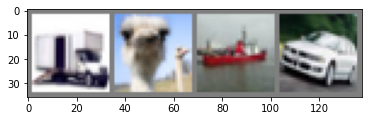

In [9]:
import numpy as np
import torchvision, torch

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(" ".join("%9s" % classes[labels[j]] for j in range(4)))

## 모델의 하이퍼파라미터 정의
- 하아퍼 파라미터 오브젝트 이름을 args 로 생성
    - 추후 SageMaker의 Script Mode 사용사에 args 오브젝트가 사용되기에, 이름을 맞추기 위해서 같은 이름을 사용 함
- 아래 파라미터는 로직 확인 용이기에, 훈련이 빨리 끝나기 위한 파라미터 값을 설정 함(에; learning rate)    

In [10]:
class Params:
    def __init__(self):
        self.workers = 4
        self.epochs = 1
        self.batch_size = 64
        self.lr = 0.1
        self.momentum = 0.9        
        self.dist_backend = 'gloo'        
        self.data_dir = '../data'        
        self.num_gpus = 1
        self.model_dir = local_model_dir
        self.current_host = 'dummy-currnet-host'
        self.hosts = 'dummpy-host'
                
args = Params()
print("# of epochs: ", args.epochs)
    

# of epochs:  1


## 로컬에서 스크래치 훈련

In [11]:
import sys, os
# src 폴더 안에 훈련 코드(예: 클래스 정의)가 있어서 경로를 Path에 추가 함
sys.path.append(os.path.join(os.getcwd(), 'source'))

In [12]:
from importlib import reload
import source.train_lib
source.train_lib = reload(source.train_lib)
from source.train_lib import train

In [13]:
%%time 

train(args)

Distributed training - True
Device Type: cuda
Loading Cifar10 dataset
Model loaded from get_model_network()
Finished Training
Saving the model.
CPU times: user 20.2 s, sys: 5.02 s, total: 25.3 s
Wall time: 20.9 s


### 훈련된 모델의 아티펙트를 리로딩
- 훈련 모델을 리로딩 테스트를 함.

In [14]:
from importlib import reload
import source.inference
source.inference = reload(source.inference)
from source.inference import model_fn


In [15]:
print("local_model_dir: ", local_model_dir)
model_fn(local_model_dir)

local_model_dir:  ../model/scratch
device:  cuda
model_file_path:  ../model/scratch/model.pth


DataParallel(
  (module): Net(
    (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (fc1): Linear(in_features=400, out_features=120, bias=True)
    (fc2): Linear(in_features=120, out_features=84, bias=True)
    (fc3): Linear(in_features=84, out_features=10, bias=True)
  )
)